# Nueral Network From Scratch

This project was is a way for me to learn the inner workings of neural networks.

I hope that by implementing them from scratch, I am better suited to utilize framekworks such as Keras or Pytorch.

The goal of this is NOT to create a super fine tuned model, showcase evaluation methadologies or over worry about the characteristics of my data.

Due to this I will be using a simple dataset from the nnfs package.

In [2]:
#load packages
import numpy as np 
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Dense layer
class Layer_Dense:
    #initialize weights to random when created
    def __init__(self, n_inputs , n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    #forward push of the model to generate a layer output based on current weights
    def forward(self, inputs): 
        layer_out=  inputs @ self.weights + self.biases 
        self.output = layer_out
        self.inputs = inputs

    def backward(self,dvalues):
        #derivative of weights is simply x due to them being product of each other sum(xi*wi) partial derivative ends up with x as a constant
        self.dweights =  self.inputs.T @ dvalues 
        #dbias is set to sum the values of the columns  due to the gradient of the bias being dbias(vector of 1s) @ dvalues
        self.dbias = np.sum(dvalues, axis=0, keepdims=True)
        #reverse logic of weights
        self.dx = dvalues @ self.weights.T  

In [4]:
#Rectified linear Unit activation function used to declare non-linearity into the model
#I was thinking of using the sigmoid function but due after further research came to the conclusion ReLU is much better at acomplishing the same thing
class Activation_ReLU:
# Forward pass
    def forward(self, inputs):
    # Calculate output values from input
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
    #Relu function has a very simple derivative as can be seen below
    def backwards(self,dvalues):
        self.drelu = np.where(self.inputs > 0 ,self.inputs,0)*dvalues
        



In [5]:
#Due to being a classification problem, softmax will yield a probability based output which we can interpret
class Activation_softmax:
# Forward pass
    def forward(self, inputs):
    # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
        self.output = probabilities
        self.inputs = inputs
    def backward(self,dvalues):
        self.dinputs = np.empty_like(dvalues)
        #Create jacobian matrix of softmax function and apply chain rule to it
        #this implementation of the jacobian of the softmax function was inspired from the following example
        #https://stackoverflow.com/questions/54976533/derivative-of-softmax-function-in-python
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues)


In [6]:
#Gradient descent is the most basic optimazation algorithm
#Like in my logistic regression model I it is a fairly simple implementation
#This time I added a learning rate decay to help in model training
class Gradient_descent:
    def __init__(self,lr,decay = 0 , iterations = 0) :
        self.lr = lr
        self.decay = decay
        self.iterations = 0
        self.lr = self.lr * (1. / (1. + self.decay * self.iterations))
        
    def forward(self,layer):
        layer.weights = layer.weights - self.lr * layer.dweights
        layer.biases = layer.biases - self.lr * layer.dbias
        
        
        
        
  

In [7]:
#The most popular loss function for classification models 
#Fairly straight forward and easy to work with
class Cross_entropy:
    #forward step declaring the loss -log(y_hat) being the simplified form of the cross entropy function 
    def forward(self,y,y_hat):
        self.y = y
        self.y_hat = y_hat
        scores = []
        y_re = self.y.reshape(-1)
        one_hot_targets = np.eye(len(np.unique(y_re)))[y_re]
        y_hat_re = self.y_hat.reshape(-1)
        for i,k in zip(one_hot_targets,y_hat):
            classes = len(i)
            ind = np.where(i == 1)
            pred_prob = k[ind]
            loss= -np.log(pred_prob)
            scores.append(loss)
        return np.array(scores)
    def backward(self,dvalues):
        #general derivative for cross entropy = -y/y_hat 
        y_re = self.y.reshape(-1)
        one_hot_targets = np.eye(len(np.unique(y_re)))[y_re]
        self.dinputs = -one_hot_targets/dvalues
        #normalize derivative values
        self.dinputs = self.dinputs / len(dvalues)


    

## Time to finally test if this works

C:\Users\Emiliano\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


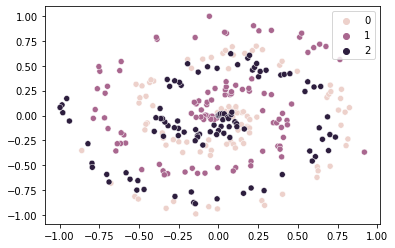

In [8]:
#load data
X, y = spiral_data(samples=100, classes=3)
sns.scatterplot(X[:,0], X[:,1],hue = y)
plt.show()

In [9]:
#basic model class I used to generate results
class Basic_Model: 
    #Declaration of model
    # dense layer -> Relu layer -> dense layer -> softmax layer -> output
    def __init__(self,X,y,lr = .5,decay = .01):
        self.y = y 
        self.X = X
        self.dense1 = Layer_Dense(2,64)
        self.relu1 = Activation_ReLU()
        self.dense2 = Layer_Dense(64,3)
        self.softmax = Activation_softmax()
        self.loss = Cross_entropy()
        self.optimizer = Gradient_descent(lr = lr,decay = decay )

    #forward iteration of model
    def forward(self):
        self.dense1.forward(self.X)
        self.relu1.forward(self.dense1.output)
        self.dense2.forward(self.relu1.output)
        self.softmax.forward(self.dense2.output)
        scores=self.loss.forward(self.y,self.softmax.output)
        return scores
    #backward step of model using the chaing rule over the various layers then using gfradient descent to tune the weights and biases
    def backward(self,iter = 0):
        self.loss.backward(self.softmax.output)
        self.softmax.backward(self.loss.dinputs)
        self.dense2.backward(self.softmax.dinputs)
        self.relu1.backwards(self.dense2.dx)
        self.dense1.backward(self.relu1.drelu)
        self.optimizer.iterations = iter
        self.optimizer.forward(self.dense1)
        self.optimizer.forward(self.dense2)
    ##general loop for trining returns loss function scores    
    def train(self,epochs = 10000): 
        scores_list = []
        for i in range(epochs):
            iter_score = self.forward()
            scores_list.append(np.mean(iter_score) )
            self.backward(iter = i)
        return scores_list

    #predict step is same as the forward step just with inputed data as well as returns the argmax of the sofrmax output
    def predict(self,x):
        self.dense1.forward(x)
        self.relu1.forward(self.dense1.output)
        self.dense2.forward(self.relu1.output)
        self.softmax.forward(self.dense2.output)
        out = np.argmax(self.softmax.output,axis = 1)
        return out



Lets use the class created to train our model

In [467]:
default_model = Basic_Model(X = X, y = y)
loss = default_model.train()

In [13]:
def plot_loss(loss,model):
    acc = np.mean(np.where(model.predict(X) == y,1,0))
    plt.plot(loss)
    plt.ylim([min(loss),max(loss)])
    plt.title(f"Minimum score = {min(loss):.3f} and a Final loss of {loss[-1]:.3f}" + f" \n At a final accuracy of {acc:.3f} ")
    plt.show()
plot_loss(loss,default_model)


seems like it is overall decreasing but very slightly and slowly, lets increase the learning rate

In [469]:
increase_lr_model = Basic_Model(X = X, y = y, lr = 2)
loss_lr_higher = increase_lr_model.train()

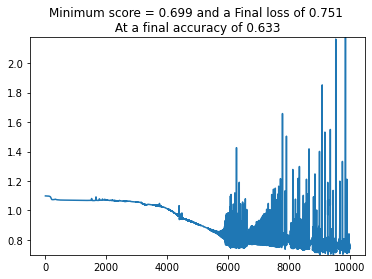

In [470]:
plot_loss(loss_lr_higher,increase_lr_model)

Seems like we are getting lower and lower but still very jumpy and not really converging 

Lets try to decrease the starting learning rate increase decrease the decay of as well as increase training epochs to compensate for higher decay and lower starting rate

In [22]:
high_decay_model = Basic_Model(X = X, y = y,lr = 1,decay=.1)
high_decay_loss = high_decay_model.train(30000)

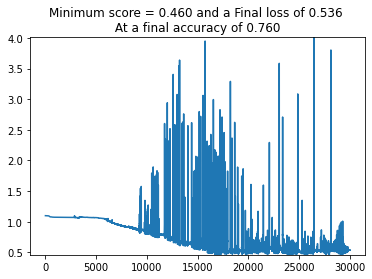

In [23]:
plot_loss(high_decay_loss,high_decay_model)

Seems like we have a pretty good loss and accuracy score here 

Now if to improve the results we would need a different optimizer such as a momentum gradient descent or Adaptive Moment Estimation(ADAM) but for the sake of this experiment I am satisfied with the performance of this simple model.

Lets try some predictions on data the model has not seen before

C:\Users\Emiliano\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


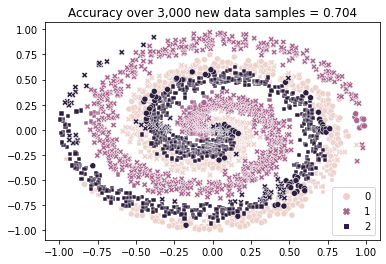

In [24]:
X, y = spiral_data(samples=1000, classes=3)
y_hat = high_decay_model.predict(x = X )
acc = np.mean(np.where(y == y_hat, 1,0) )
plt.title(f"Accuracy over 3,000 new data samples = {acc:.3f}")
sns.scatterplot(X[:,0], X[:,1],hue = y,style =y_hat )
plt.show()

Now overall I am pretty happy with the results of this experiment as it has helped me gain a much deeper understanding of nueral networks and their inner workins.

Over-all the goal of this project was not to create the best model, evaluate it and fine tune it, but to take a peak into the black box that is deep learning. 

In the future I hope to use nueral networks a lot more and be able to learn much more about them now that I have a good graps of the fundamentals.